# Test sampling algorithms

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ment

In [2]:
plt.style.use("../style.mplstyle")

## Create distribution

In [3]:
class RingDistribution:
    def __init__(self) -> None:
        self.ndim = 2

    def prob(self, x: np.ndarray) -> np.ndarray:
        x1 = x[:, 0]
        x2 = x[:, 1]
        log_prob = np.sin(np.pi * x1) - 2.0 * (x1**2 + x2**2 - 2.0) ** 2
        return np.exp(log_prob)

    def prob_grid(
        self, shape: tuple[int], limits: list[tuple[float, float]]
    ) -> tuple[np.ndarray, list[np.ndarray]]:
        edges = [
            np.linspace(limits[i][0], limits[i][1], shape[i] + 1)
            for i in range(self.ndim)
        ]
        coords = [0.5 * (e[:-1] + e[1:]) for e in edges]
        points = np.stack(
            [c.ravel() for c in np.meshgrid(*coords, indexing="ij")], axis=-1
        )
        values = self.prob(points)
        values = values.reshape(shape)
        return values, coords

In [4]:
ndim = 2
xmax = 3.0
dist = RingDistribution()

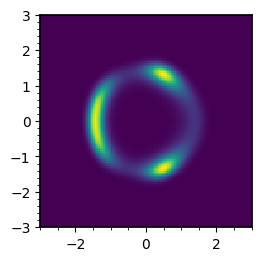

In [5]:
grid_limits = 2 * [(-xmax, xmax)]
grid_shape = (128, 128)
grid_values, grid_coords = dist.prob_grid(grid_shape, grid_limits)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
plt.show()

In [6]:
def plot_samples(x_pred: np.ndarray) -> tuple:
    fig, axs = plt.subplots(ncols=2, figsize=(5.0, 2.75), sharex=True, sharey=True)
    hist, edges = np.histogramdd(x_pred, bins=80, range=grid_limits)
    axs[0].pcolormesh(edges[0], edges[1], hist.T)
    axs[1].pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
    axs[0].set_title("PRED", fontsize="medium")
    axs[1].set_title("TRUE", fontsize="medium")
    return fig, axs

In [7]:
def evaluate_sampler(sampler, size: int = 100_000):
    x_pred = sampler(dist.prob, size=size)
    return plot_samples(x_pred)

## Grid sampler

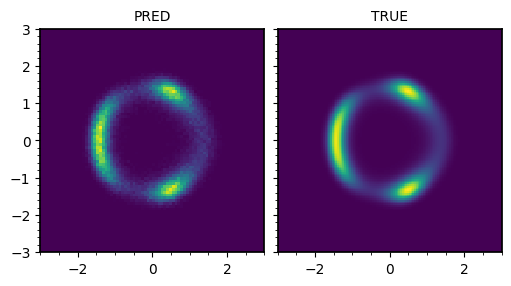

In [8]:
sampler = ment.GridSampler(grid_limits=grid_limits, grid_shape=grid_shape)

evaluate_sampler(sampler);

## Metropolis-Hastings sampler

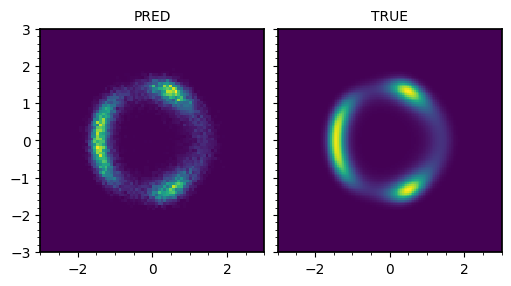

In [9]:
chains = 4
proposal_cov = np.identity(ndim) * 0.25
start_loc = np.zeros(ndim)
start_cov = np.identity(ndim) * 0.25
start_point = np.random.multivariate_normal(start_loc, start_cov, size=chains)

sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=proposal_cov,
    start=start_point,
    chains=chains,
    burnin=0,
)
evaluate_sampler(sampler);

## No-Underrun Sampler (NURS)